In [1]:
import numpy as np

from tensorflow.keras.applications import ResNet50
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt

In [2]:
model = ResNet50(weights='imagenet')

BATCH_SIZE = 32
url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = 255*np.array(
    np.repeat(
        np.expand_dims(
            np.array(img, dtype=np.float32), axis=0
        ), BATCH_SIZE, axis=0
    ), dtype=np.float32
)

input_batch.shape

(32, 224, 224, 3)

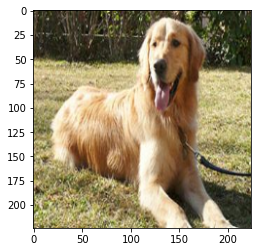

In [3]:
plt.imshow(input_batch[0]/255)

In [4]:
predictions = model.predict(input_batch) # warm up
np.argmax(predictions,axis=1)

1/1 [==============================] - 3s 3s/step


array([160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160], dtype=int64)

In [5]:
!trtexec --onnx=model.onnx --saveEngine=model.plan  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16

&&&& RUNNING TensorRT.trtexec [TensorRT v8501] # trtexec --onnx=model.onnx --saveEngine=model.plan --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[12/14/2022-15:22:06] [I] === Model Options ===


[12/14/2022-15:22:06] [W] --explicitBatch flag has been deprecated and has no effect!
[12/14/2022-15:22:06] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[12/14/2022-15:22:08] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[12/14/2022-15:22:08] [W] [TRT] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[12/14/2022-15:22:09] [W] [TRT] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.1.0
[12/14/2022-15:23:12] [E] Error[2]: [virtualMemoryBuffer.cpp::nvinfer1::StdVirtualMemoryBufferImpl::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[12/14/2022-15:23:12] [E] Error[2]: [virtualMemoryBuffer.cpp::nvinfer1::St

[12/14/2022-15:22:06] [I] Format: ONNX
[12/14/2022-15:22:06] [I] Model: model.onnx
[12/14/2022-15:22:06] [I] Output:
[12/14/2022-15:22:06] [I] === Build Options ===
[12/14/2022-15:22:06] [I] Max batch: explicit batch
[12/14/2022-15:22:06] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[12/14/2022-15:22:06] [I] minTiming: 1
[12/14/2022-15:22:06] [I] avgTiming: 8
[12/14/2022-15:22:06] [I] Precision: FP32+FP16
[12/14/2022-15:22:06] [I] LayerPrecisions: 
[12/14/2022-15:22:06] [I] Calibration: 
[12/14/2022-15:22:06] [I] Refit: Disabled
[12/14/2022-15:22:06] [I] Sparsity: Disabled
[12/14/2022-15:22:06] [I] Safe mode: Disabled
[12/14/2022-15:22:06] [I] DirectIO mode: Disabled
[12/14/2022-15:22:06] [I] Restricted mode: Disabled
[12/14/2022-15:22:06] [I] Build only: Disabled
[12/14/2022-15:22:06] [I] Save engine: model.plan
[12/14/2022-15:22:06] [I] Load engine: 
[12/14/2022-15:22:06] [I] Profiling verbosity: 0
[12/14/2022-15:22:06] [I] Tac

[12/14/2022-15:23:12] [W] [TRT] Requested amount of GPU memory (8589934592 bytes) could not be allocated. There may not be enough free memory for allocation to succeed.
[12/14/2022-15:23:12] [W] [TRT] Skipping tactic 8 due to insufficient memory on requested size of 8589934592 detected for tactic 0x000000000000003c.
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
[12/14/2022-15:23:12] [E] Error[2]: [virtualMemoryBuffer.cpp::nvinfer1::StdVirtualMemoryBufferImpl::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[12/14/2022-15:23:12] [E] Error[2]: [virtualMemoryBuffer.cpp::nvinfer1::StdVirtualMemoryBufferImpl::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[12/14/2022-15:23:12] [W] [TRT] Requested amount of GPU memory (8589934592 bytes) could not be allocated. There may not be enough free memory for allocation to succeed.
[12/14/2022-15:23:12] [W] [TRT] Skipping tactic 13 due to insufficient memory on requested s

In [6]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("model.plan", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()


[12/14/2022-15:23:19] [I] Trace averages of 10 runs:
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 16.8362 ms - Host latency: 17.6127 ms (enqueue 0.692043 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 17.1073 ms - Host latency: 17.8855 ms (enqueue 0.497733 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 16.5581 ms - Host latency: 17.3521 ms (enqueue 0.78869 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 16.8851 ms - Host latency: 17.7714 ms (enqueue 0.542432 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 15.4984 ms - Host latency: 16.2876 ms (enqueue 1.13838 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 16.8263 ms - Host latency: 17.7072 ms (enqueue 0.535486 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 15.88 ms - Host latency: 16.6564 ms (enqueue 0.485046 ms)
[12/14/2022-15:23:19] [I] Average on 10 runs - GPU latency: 16.0837 ms - Host latency: 16.8728 ms (enqueue 0.5

In [7]:
target_dtype = np.float16
input_batch = input_batch.astype(target_dtype)

output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) 

# Allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

In [8]:
def predict(batch): 
    # Transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # Execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # Transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # Syncronize threads
    stream.synchronize()
    
    return output

In [9]:
print("Warming up...")

trt_predictions = predict(input_batch).astype(np.float32)

print("Done warming up!")

Warming up...
Done warming up!


In [10]:
np.argmax(trt_predictions,axis=1)

array([160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160], dtype=int64)

In [11]:
%%timeit

_ = predict(input_batch) 

16.9 ms ± 64.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%time

_ = predict(input_batch)

CPU times: total: 15.6 ms
Wall time: 20.4 ms
